In [32]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
#Combined model
df_images = pd.read_csv(r"C:\Users\Mirka Gemelova\OneDrive - ITU\Dokumenty\ITU\DS_project\2025-FYP-groupG\model_features.csv")
df_images2 = pd.read_csv(r"C:\Users\Mirka Gemelova\Downloads\features2.csv")
df_metadata = pd.read_csv(r"C:\Users\Mirka Gemelova\OneDrive - ITU\Dokumenty\ITU\DS_project\2025-FYP-groupG\important files to be deleted\metadata.csv")
combined_df = combined_df.dropna()


In [34]:
print(df_metadata.shape) #ImageID of removed image: PAT_987_1859_859
print(df_images.shape)
df_images['img_id'] = df_images2['ID']
combined_df = pd.merge(df_images, df_metadata, on='img_id', how='inner')
print(combined_df.shape)

(2298, 26)
(1473, 7)
(1473, 33)


In [37]:
#Data cleaning to be suitable for model
combined_df.replace("True", 1, inplace=True)
combined_df.replace("False", 0, inplace=True)
combined_df.replace(True, 1, inplace=True)
combined_df.replace(False, 0, inplace=True)
combined_df.replace("UNK", float("NaN"), inplace=True)

C:\Users\Mirka Gemelova\AppData\Local\Temp\ipykernel_29296\2042539058.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace("True", 1, inplace=True)
C:\Users\Mirka Gemelova\AppData\Local\Temp\ipykernel_29296\2042539058.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace(False, 0, inplace=True)
C:\Users\Mirka Gemelova\AppData\Local\Temp\ipykernel_29296\2042539058.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behav

In [41]:
combined_df = combined_df.drop(columns=['biopsed','img_id','patient_id', 'lesion_id', 'background_father',
      'background_mother', 'has_piped_water',
      'has_sewage_system', 'fitspatrick', 'region', 'diagnostic'])

print(combined_df.columns)
combined_df.head(5)

Index(['A - worst asymmetry', 'B - compactness', 'C - red variance',
       'C - green variance', 'C - blue variance', 'Hair', 'Cancer', 'smoke',
       'drink', 'age', 'pesticide', 'gender', 'skin_cancer_history',
       'cancer_history', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt',
       'changed', 'bleed', 'elevation'],
      dtype='object')


,A - worst asymmetry,B - compactness,C - red variance,C - green variance,C - blue variance,Hair,Cancer,smoke,drink,age,...,skin_cancer_history,cancer_history,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation
0,8.580224e+08,30.588197,74.546797,85.081084,86.207771,0.083847,0,0,0,14,...,0,1,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.190781e+06,201.571233,0.282972,0.534548,0.588560,0.031879,0,0,0,14,...,0,1,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.408456e+06,-1.067555,0.366330,0.496921,0.588388,0.070319,1,1,1,59,...,0,0,20.0,15.0,1.0,1.0,1.0,0.0,1.0,1.0
3,1.853331e+06,-2.390464,2.952702,3.592146,4.158397,0.197232,1,1,1,59,...,0,0,20.0,15.0,1.0,1.0,1.0,0.0,1.0,1.0
4,2.544890e+06,0.713480,0.615600,2.970867,3.926450,0.083589,1,1,1,59,...,0,0,20.0,15.0,1.0,1.0,1.0,0.0,1.0,1.0


x_train : (791, 13)
y_train : (791,)
x_test : (198, 13)
y_test : (198,)


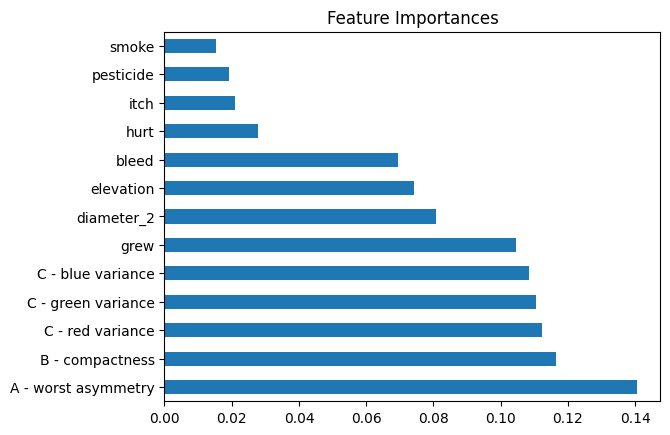

In [62]:
features_to_include = ['A - worst asymmetry', 'B - compactness', 'C - red variance',
       'C - green variance', 'C - blue variance', 
       'bleed', 'elevation', 'grew', 'hurt', 'itch', 'diameter_2', 'pesticide', 
       'smoke']

y = combined_df['Cancer'].copy()
x = combined_df[features_to_include]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101) #stratify = y makes sure that both training and test sets preserve the original class proportions.

print(f'x_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_test : {y_test.shape}')

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances")
plt.show()

In [63]:
param_grid = [{
    'n_estimators':[100,200,500], #More trees = better performance up to a point, then diminishing returns.
    'max_depth': [3, 5, 10, 20], #higher the values the more we risk overfitting
    'criterion': ['entropy', 'gini'], #can also comment this out
    'min_samples_split': [5,10,15], # minimum number of samples a node must have to be split into two child nodes in a decision tree. Default is 2 (canm overfit)
    'min_samples_leaf': [1, 2, 4]#,
    #'max_features': ['sqrt', None]

}]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
grid_search = GridSearchCV(rf_model,
                           param_grid,
                           cv=skf, #this splits testing data to test and validation based on cancer/non-cancer proportions (so they have same percentage of cancer)
                                    #if we use this, we dont have to split training data ourselves at the beginning
                           scoring = 'recall',
                           n_jobs=-1,                          
                           )

grid_search.fit(x_train, y_train)

print(f'Grid search best score: {grid_search.best_score_}')
print(f'Grid search best parameters: {grid_search.best_params_}')

#Training the rf with what criteria recomended by grid search (= best parameters)
best_params = grid_search.best_params_

Grid search best score: 0.947139282735613
Grid search best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


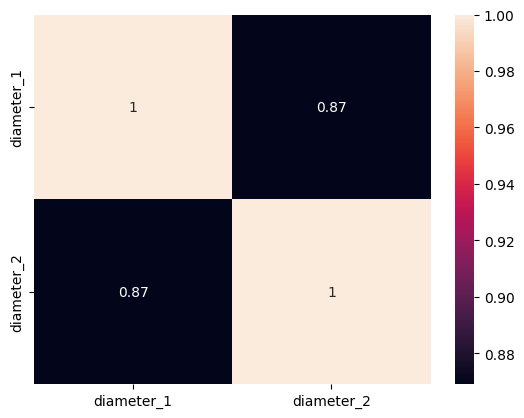

,diameter_1,diameter_2,Cancer
diameter_1,1.000000,0.869063,0.106564
diameter_2,0.869063,1.000000,0.110892
Cancer,0.106564,0.110892,1.000000


In [ ]:
corr = combined_df[['diameter_1', 'diameter_2']].corr()
sns.heatmap(corr, annot=True)
plt.show()
2
combined_df[['diameter_1', 'diameter_2', 'Cancer']].corr()

In [ ]:
combined_df[features_to_include + ['Cancer']].corr()['Cancer'].sort_values(ascending=False)

#our criteria: use everything above 0.05 correlation
# grew                   0.416786
# bleed                  0.357533
# elevation              0.341569
# hurt                   0.262078
# diameter_2             0.110892
# diameter_2             0.110892
# diameter_1             0.106564
# smoke                  0.085737
# itch                   0.070621

Cancer                 1.000000
grew                   0.416786
bleed                  0.357533
elevation              0.341569
hurt                   0.262078
diameter_2             0.110892
diameter_2             0.110892
diameter_1             0.106564
smoke                  0.085737
itch                   0.070621
pesticide              0.055429
pesticide              0.055429
drink                  0.046641
age                    0.042979
skin_cancer_history    0.008945
cancer_history        -0.002468
cancer_history        -0.002468
C - green variance    -0.021594
C - red variance      -0.022197
C - blue variance     -0.032448
B - compactness       -0.059254
A - worst asymmetry   -0.075649
Name: Cancer, dtype: float64